# Bayesian A/B Test Analysis: Continuous Outcomes (Spend)

This notebook performs a Bayesian analysis of an A/B test for a **continuous metric like Average Spend Per User**. In this scenario, we have to account for the following two points:

1. **Point Mass at Zero:** A large number of users typically spend nothing.
2. **Positive Skew:** Among users who do spend, most spend a little, while a few "whales" spend a lot, creating a long right tail.

To handle this, we use a **Bayesian Hurdle Model**. It models two separate user behaviors:

- **Part 1 (The "Hurdle"):** What is the probability a user will spend *anything at all*? This is a binary outcome modeled with a **Bernoulli** distribution.
- **Part 2 (The Amount):** *For users who clear the hurdle* (i.e., spend more than zero), what is the distribution of their spending? This is modeled with a **Gamma** distribution, which is ideal for skewed, positive data like monetary values.

By combining the posteriors of these two parts, we can derive the posterior distribution for the overall **Average Spend Per User** and the difference between the control and treatment groups.

### 1. Data Input & Configuration

#### 1.1 Data Input
**➡️ Action Required:** Replace the synthetic data generation below with your actual spend data.

The data for `SPEND_DATA_CONTROL` and `SPEND_DATA_TREATMENT` should be a list or NumPy array for each group, where each element is the spend amount for a single user. Crucially, you must include all the zero-spend users in these arrays.

The cell below generates realistic synthetic data for demonstration purposes.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, beta
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from matplotlib.lines import Line2D # Import for robust legend creation

# Set plotting style
sns.set_style("whitegrid")

#### --- SYNTHETIC DATA GENERATION (REPLACE WITH YOUR DATA) ---
np.random.seed(42) # for reproducibility

# --- Control Group Data Generation ---
total_users_control = 1_100_000
conversion_rate_control = 0.05 # 5% of users spend something
spenders_control = int(total_users_control * conversion_rate_control)
non_spenders_control = total_users_control - spenders_control
# Spends for those who convert, modeled by a Gamma distribution (Mean = shape / rate, scale = 1/rate. Mean = shape * scale = 2 * 10 = €20)
# In scipy, scale = 1/beta_rate
generated_positive_spends_control = np.random.gamma(shape=2, scale=10, size=spenders_control)
generated_zero_spends_control = np.zeros(non_spenders_control)
SPEND_DATA_CONTROL = np.concatenate([generated_positive_spends_control, generated_zero_spends_control])
np.random.shuffle(SPEND_DATA_CONTROL)

# --- Treatment Group Data Generation ---
# Assume treatment increases both conversion rate and average spend of spenders
total_users_treatment = 1_150_000
conversion_rate_treatment = 0.055 # 5.5% conversion rate
spenders_treatment = int(total_users_treatment * conversion_rate_treatment)
non_spenders_treatment = total_users_treatment - spenders_treatment
# Spends for those who convert, slightly higher average (Mean = 2 * 11 = €22)
generated_positive_spends_treatment = np.random.gamma(shape=2, scale=11, size=spenders_treatment)
generated_zero_spends_treatment = np.zeros(non_spenders_treatment)
SPEND_DATA_TREATMENT = np.concatenate([generated_positive_spends_treatment, generated_zero_spends_treatment])
np.random.shuffle(SPEND_DATA_TREATMENT)

# --- Observed Data Summary ---
c_spenders_obs = (SPEND_DATA_CONTROL > 0).sum()
t_spenders_obs = (SPEND_DATA_TREATMENT > 0).sum()

print("--- Observed Data Summary ---")
print(f"Control Group: {len(SPEND_DATA_CONTROL):,} users.")
print(f"  - Overall Avg. Spend: €{np.mean(SPEND_DATA_CONTROL):.4f}")
print(f"  - Spender Rate: {c_spenders_obs / len(SPEND_DATA_CONTROL):.3%}")
print(f"  - Avg. Spend of Spenders: €{np.mean(SPEND_DATA_CONTROL[SPEND_DATA_CONTROL > 0]):.2f}\n")

print(f"Treatment Group: {len(SPEND_DATA_TREATMENT):,} users.")
print(f"  - Overall Avg. Spend: €{np.mean(SPEND_DATA_TREATMENT):.4f}")
print(f"  - Spender Rate: {t_spenders_obs / len(SPEND_DATA_TREATMENT):.3%}")
print(f"  - Avg. Spend of Spenders: €{np.mean(SPEND_DATA_TREATMENT[SPEND_DATA_TREATMENT > 0]):.2f}")

--- Observed Data Summary ---
Control Group: 1,100,000 users.
  - Overall Avg. Spend: €0.9999
  - Spender Rate: 5.000%
  - Avg. Spend of Spenders: €20.00

Treatment Group: 1,150,000 users.
  - Overall Avg. Spend: €1.2073
  - Spender Rate: 5.500%
  - Avg. Spend of Spenders: €21.95


#### 1.2 Visualizing the Positive Spend Data

Before we model the data, let's visualize the distribution of spends for users who actually made a purchase (i.e., spend > 0). This helps us confirm the assumed shape of the data. We expect to see a distribution with a strong positive (right) skew, which justifies our choice of the Gamma distribution. The plot below shows histograms, truncating the x-axis at the 99th percentile to focus on the bulk of the distribution.

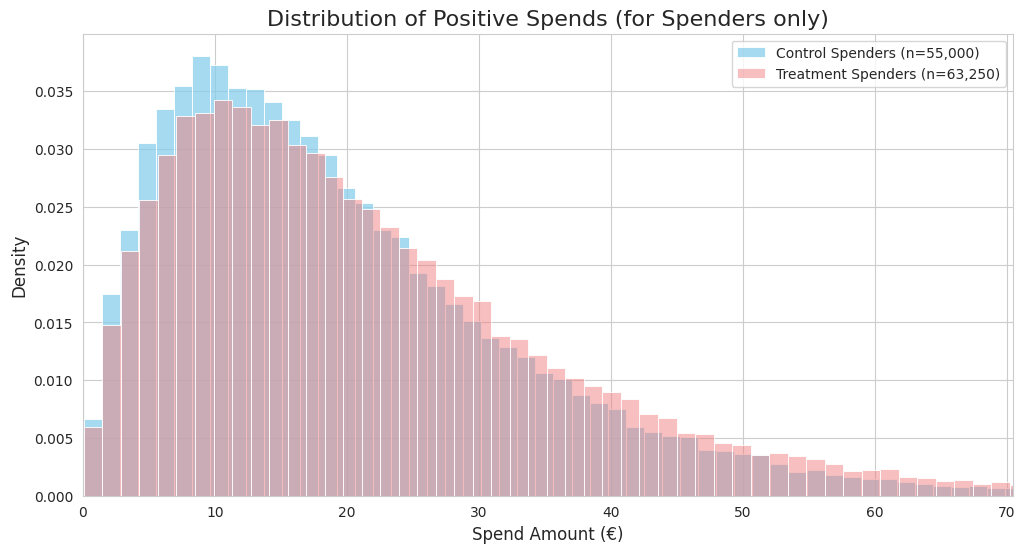

In [2]:
# --- Isolate positive spends for visualization ---
positive_spends_control_viz = SPEND_DATA_CONTROL[SPEND_DATA_CONTROL > 0]
positive_spends_treatment_viz = SPEND_DATA_TREATMENT[SPEND_DATA_TREATMENT > 0]

# --- Create Visualization ---
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histograms
sns.histplot(positive_spends_control_viz, ax=ax, bins=100, label=f'Control Spenders (n={len(positive_spends_control_viz):,})', color='skyblue', stat='density')
sns.histplot(positive_spends_treatment_viz, ax=ax, bins=100, label=f'Treatment Spenders (n={len(positive_spends_treatment_viz):,})', color='lightcoral', stat='density', alpha=0.5)

# Set a sensible x-limit to view the bulk of the data
# This avoids the long tail making the main body of the distribution unreadable
limit = np.percentile(np.concatenate([positive_spends_control_viz, positive_spends_treatment_viz]), 99)
ax.set_xlim(0, limit)

ax.set_title('Distribution of Positive Spends (for Spenders only)', fontsize=16)
ax.set_xlabel('Spend Amount (€)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend()
plt.show()

#### 1.3. Analysis Configuration
- `METRIC_NAME_SPEND`: A descriptive string for the overall metric you're testing (e.g., "Average Spend Per User").
  Used in plot titles and analysis summaries.
- `N_SAMPLES`: The number of samples to draw in the **Monte Carlo simulation**.
  A large number (e.g., 500,000) is used to approximate the posterior distributions. This allows us to compute probabilities, credible intervals, and estimate the difference in performance between groups. The larger this number, the more accurate the estimations.
- `PRACTICAL_SIGNIFICANCE_SPEND_RELATIVE`: The minimum **relative** change in the average spend that you consider practically meaningful.
  Example: If your control group's average spend is €1.00 and you set this to `0.05` (5%), you are asking:
  *"What is the probability that the treatment group’s average spend is at least 5% greater than the control group's (i.e., an average spend of €1.05)?"*

In [3]:
# --- ANALYSIS PARAMETERS ---
METRIC_NAME_SPEND = "Average Spend Per User"

# For spend, a relative threshold is often preferred (e.g., we want to see a lift of at least 5%)
PRACTICAL_SIGNIFICANCE_SPEND_RELATIVE = 0.05 # 5% relative uplift threshold

# Number of samples to draw from posteriors for simulation
N_SAMPLES = 500_000

### 2. Model Definition: A Pragmatic Shortcut for Speed

This method is extremely fast and scalable because it uses a pragmatic approach that combines Bayesian principles with a data-driven shortcut. This allows us to compute the posterior distributions with direct formulas instead of slow computational methods like MCMC or Variational Inference.

- **Hurdle (Probability of Spending `p`):** This is a standard Bayesian update using a conjugate prior.
  - **Prior Distribution:** We use the **Jeffreys prior**, which corresponds to a `Beta(0.5, 0.5)` distribution. This is a widely accepted *uninformative* prior that encodes minimal assumptions, allowing the data to drive the results. This choice is especially appropriate given the large sample sizes common in A/B testing.
  - **Why Jeffreys?** It avoids the subjectivity of incorporating historical data and is **invariant under reparameterization**, meaning that inferences remain consistent even if we transform the parameter (e.g., from `p` to `log-odds(p)`).
  - **Posterior:** The posterior for `p` is also a Beta distribution, a property known as **conjugacy**: `Posterior ~ Beta(0.5 + num_spenders, 0.5 + num_non_spenders)`.

- **Amount (Conditional Spend):** This is where the shortcut happens.
  - **The Goal:** We want to model the spend amount with a `Gamma(α, β)` distribution. The mean is `α / β`. Our treatment might affect the mean, so we need to estimate a posterior for `α` and `β`.
  - **The Challenge:** There is no simple, direct formula (i.e., no conjugacy) for the joint posterior of *both* `α` and `β`. Estimating them would require a full probabilistic model using MCMC (e.g., with PyMC or Stan), which can be computationally intensive and slow, especially with millions of data points.
  - **The Pragmatic Solution:** We make a simplifying assumption: **the *shape* (`α`) of spending is stable and well-defined by our large dataset, while the *scale/rate* (`β`) is what the A/B test is primarily influencing.**
    1.  **Fix `α` as a Point Estimate:** With tens or hundreds of thousands of spenders, the Law of Large Numbers suggests we can get a precise point estimate for the shape parameter `α` directly from the data. The uncertainty around this estimate is so small it can be considered negligible for practical purposes. We calculate it using the "method of moments" (`α = mean² / variance`) and treat it as a known, fixed number.
    2.  **Unlock Conjugacy for `β`:** By fixing `α`, we unlock a powerful property. The conjugate prior for the rate parameter `β` of a Gamma likelihood (when `α` is known) is another **Gamma distribution**.
    3.  **Fast Posterior:** This means we can now calculate the posterior for `β` with a simple formula: `Posterior(β) ~ Gamma(α_prior + N*α_data, β_prior + sum_of_spends)`. This is computationally trivial.

> **An Intuitive View of Alpha (α) and Beta (β):**
>
> - **`α_shape`** represents the *psychology* or *heterogeneity* of spending. Is the customer base homogeneous in their spending habits (high `α`, distribution is more symmetric and bell-shaped)? Or is it a "whale" economy where a few big spenders dominate (low `α`, distribution is highly skewed with a long tail)? We assume this underlying customer behavior is fundamental and not something our A/B test could realistically change.
> - **`β_rate`** represents the *magnitude* of spending. Does the new feature encourage people to spend more or less on average? This is what we expect our experiment to influence. By fixing `α`, we attribute any change in the mean spend (`α/β`) to a change in `β`.

#### Formal Model Specification
For each group (Control/Treatment), the model can be formally written as:

1.  **Hurdle Model (Probability of Spending):**
    - Data: `is_spender_i ~ Bernoulli(p)`
    - Prior: `p ~ Beta(α_p=0.5, β_p=0.5)` (Jeffreys Prior)
    - Posterior: `p | data ~ Beta(α_p + Σ(is_spender), β_p + N - Σ(is_spender))`

2.  **Amount Model (Conditional Spend Amount):**
    - Data: `spend_i | is_spender_i=1 ~ Gamma(α_est, β_rate)`
    - Fixed Parameter: `α_est` is a point estimate calculated from the positive spend data for the entire dataset using the method of moments.
    - Prior: `β_rate ~ Gamma(α_r=0.01, β_r=0.01)` (Weakly Informative Prior)
    - Posterior: `β_rate | data ~ Gamma(α_r + N_spenders*α_est, β_r + Σ(spend))`

3.  **Overall Metric (Average Spend Per User):**
    - Derived Quantity: `μ = p * E[spend] = p * (α_est / β_rate)`

In [4]:
# --- Prepare data for Hurdle Model ---

# Binary indicator (did they spend?)
spent_binary_control = (SPEND_DATA_CONTROL > 0).astype(int)
spent_binary_treatment = (SPEND_DATA_TREATMENT > 0).astype(int)

# Positive spend amounts
positive_spends_control = SPEND_DATA_CONTROL[SPEND_DATA_CONTROL > 0]
positive_spends_treatment = SPEND_DATA_TREATMENT[SPEND_DATA_TREATMENT > 0]


# --- Part 1: Beta-Bernoulli Model for the HURDLE (Probability of spending) ---
# Priors (Jeffreys Beta(0.5, 0.5))
prior_alpha_beta, prior_beta_beta = 0.5, 0.5

# Control group posterior
c_spenders = np.sum(spent_binary_control)
c_total = len(spent_binary_control)
p_control_posterior = beta(prior_alpha_beta + c_spenders, prior_beta_beta + (c_total - c_spenders))

# Treatment group posterior
t_spenders = np.sum(spent_binary_treatment)
t_total = len(spent_binary_treatment)
p_treatment_posterior = beta(prior_alpha_beta + t_spenders, prior_beta_beta + (t_total - t_spenders))

# --- Part 2: Gamma-Gamma Model for the AMOUNT (Conditional on spending > 0) ---
# Empirical Bayes: Estimate the shape param 'alpha' from the data using method of moments
def estimate_gamma_shape(data):
    mean = np.mean(data)
    var = np.var(data)
    if var == 0: return 1 # Avoid division by zero, return a neutral shape
    return mean**2 / var

# In line with our pragmatic assumption, we estimate a single, fixed shape parameter 'alpha'
# by pooling the positive spend data from both groups. We assume the "shape" of spending
# behavior is stable and not affected by the experiment, while the "rate" is what changes.
pooled_positive_spends = np.concatenate([positive_spends_control, positive_spends_treatment])
alpha_est = estimate_gamma_shape(pooled_positive_spends)

# --- Sanity Check for the Pooled Alpha Assumption ---
alpha_est_control = estimate_gamma_shape(positive_spends_control)
alpha_est_treatment = estimate_gamma_shape(positive_spends_treatment)
print("--- Sanity Check on Shape (α) Parameter ---")
print(f"Shape estimated from Control only:   {alpha_est_control:.3f}")
print(f"Shape estimated from Treatment only: {alpha_est_treatment:.3f}")
print(f"Shape estimated from Pooled data:    {alpha_est:.3f}")
print("-> If the control and treatment shapes are very different, the pooled shape assumption is weaker.\n")

# Priors for the rate parameter 'beta_rate' (Weakly informative Gamma(0.01, 0.01))
prior_alpha_rate, prior_beta_rate = 0.01, 0.01

# Control group posterior for the rate 'beta_rate'
# Note: scipy.stats.gamma uses 'scale' which is 1/rate. So we calculate the posterior rate and then invert it for the scale parameter.
posterior_alpha_rate_control = prior_alpha_rate + len(positive_spends_control) * alpha_est
posterior_beta_rate_control = prior_beta_rate + np.sum(positive_spends_control)
beta_rate_control_posterior = gamma(a=posterior_alpha_rate_control, scale=1 / posterior_beta_rate_control)

# Treatment group posterior for the rate 'beta_rate'
posterior_alpha_rate_treatment = prior_alpha_rate + len(positive_spends_treatment) * alpha_est
posterior_beta_rate_treatment = prior_beta_rate + np.sum(positive_spends_treatment)
beta_rate_treatment_posterior = gamma(a=posterior_alpha_rate_treatment, scale=1 / posterior_beta_rate_treatment)

# --- Combine Posteriors by Sampling ---
# Now we draw samples from these analytical posteriors to simulate the posteriors of our metrics of interest

# Component 1: Probability to Spend
p_control_samples = p_control_posterior.rvs(size=N_SAMPLES)
p_treatment_samples = p_treatment_posterior.rvs(size=N_SAMPLES)

# Component 2: Average Spend per Spender
beta_rate_control_samples = beta_rate_control_posterior.rvs(size=N_SAMPLES)
beta_rate_treatment_samples = beta_rate_treatment_posterior.rvs(size=N_SAMPLES)
# Avg spend of spenders = alpha_shape / beta_rate
avg_spend_control_samples = alpha_est / beta_rate_control_samples
avg_spend_treatment_samples = alpha_est / beta_rate_treatment_samples

# Overall Metric: Average Spend Per User
# Overall Avg Spend (mu) = p * (avg spend of spenders)
mu_control_samples = p_control_samples * avg_spend_control_samples
mu_treatment_samples = p_treatment_samples * avg_spend_treatment_samples

# --- Calculate Posterior Differences ---
# Differences for components
diff_p_abs_samples = p_treatment_samples - p_control_samples
diff_p_rel_samples = (p_treatment_samples - p_control_samples) / p_control_samples
diff_avg_spend_abs_samples = avg_spend_treatment_samples - avg_spend_control_samples
diff_avg_spend_rel_samples = (avg_spend_treatment_samples - avg_spend_control_samples) / avg_spend_control_samples

# Differences for the overall metric
diff_mu_abs_samples = mu_treatment_samples - mu_control_samples
diff_mu_rel_samples = (mu_treatment_samples - mu_control_samples) / mu_control_samples

--- Sanity Check on Shape (α) Parameter ---
Shape estimated from Control only:   1.993
Shape estimated from Treatment only: 1.989
Shape estimated from Pooled data:    1.978
-> If the control and treatment shapes are very different, the pooled shape assumption is weaker.



### 3. Overall Results: Average Spend Per User

This section focuses on the primary metric: the overall **Average Spend Per User**, which combines the probability of spending with the amount spent. It answers the main business question: "Did the treatment cause a meaningful change in overall revenue per user?"

#### Key Metrics
- **Probability Treatment > Control**: The probability that the treatment's true average spend is higher than the control's.
- **Probability of Practical Significance**: The probability the treatment's true relative uplift exceeds our defined threshold (e.g., > 5% lift).
- **Expected Change (Absolute & Relative)**: Our best estimate for the change in average spend, given by the mean of the posterior difference.
- **95% Highest Density Interval (HDI)**: The range where we are 95% certain the true change lies. If this interval is entirely above zero, it provides strong evidence for a positive effect.

#### 3.1. Individual Group Posterior Estimates

Before analyzing the *difference* between the groups, we first examine the posterior distributions for the primary metric in each group. This tells us the model's estimate for the **Average Spend Per User** for the control and treatment groups individually, along with our uncertainty about those estimates.

- **Expected Value**: The mean of the posterior distribution, which serves as our best point estimate for the metric.
- **95% Highest Density Interval (HDI)**: The interval where we believe the true value of the metric lies with 95% probability.

--- 3.1 Individual Group Estimates for Average Spend Per User ---
Control Group:
  - Expected Value: €0.9999
  - 95% HDI: [€0.9899, €1.0101]

Treatment Group:
  - Expected Value: €1.2073
  - 95% HDI: [€1.1959, €1.2185]


--- 3.2 Change Analysis for Average Spend Per User (Treatment vs. Control) ---

Probabilities:
  - Probability Treatment > Control: 100.00%
  - Prob. Treatment is Practically Significant: 100.00%
    (The probability the relative spend increase exceeds our threshold of 5.0%)

Relative Change Estimation (% Treatment vs % Control):
  - Expected Relative Change: 20.74%
  - 95% Highest Density Interval (HDI): [19.08%, 22.41%]

Absolute Change Estimation (€ Treatment - € Control):
  - Expected Absolute Change: €0.2074
  - 95% Highest Density Interval (HDI): [€0.1921, €0.2225]


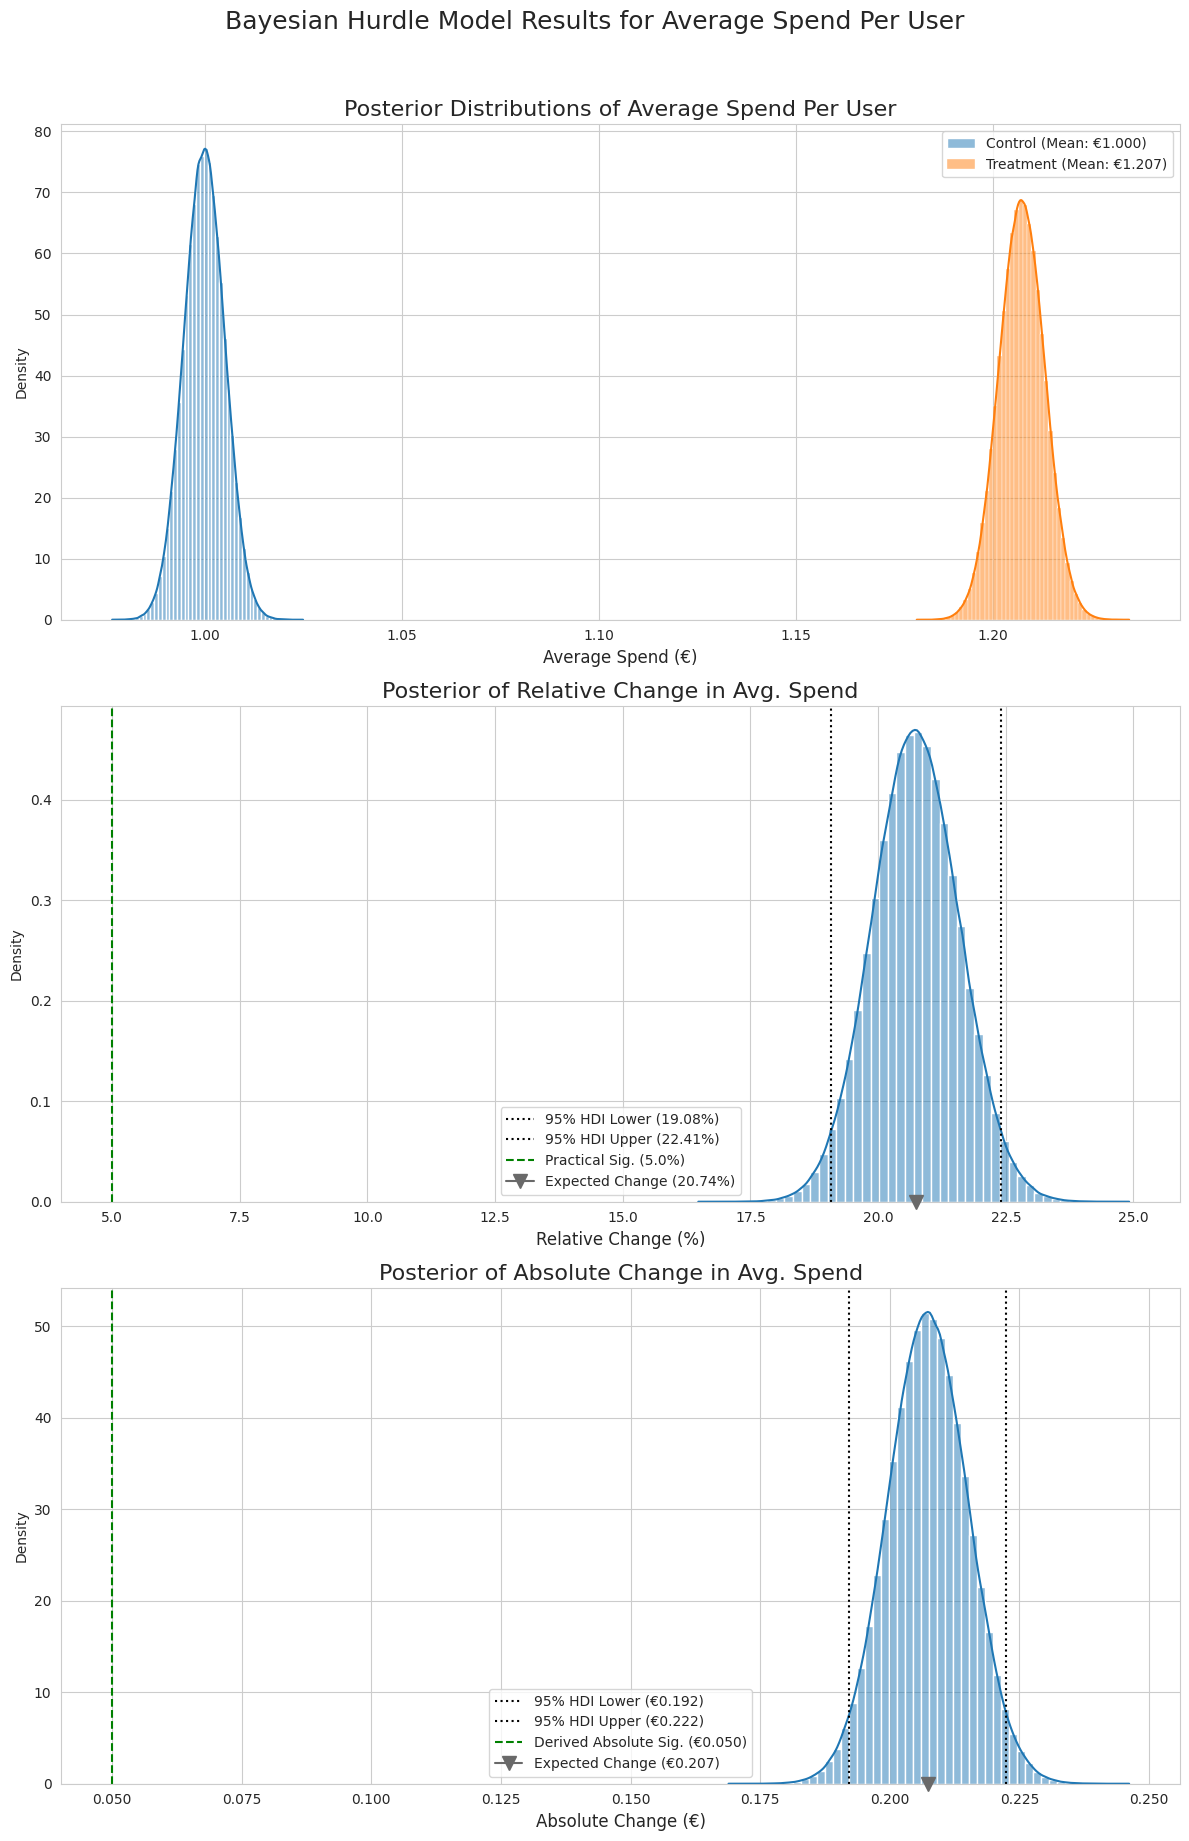

In [5]:
# --- Calculate Core Metrics from posterior samples ---
prob_treatment_is_greater_spend = np.mean(diff_mu_abs_samples > 0)
prob_treatment_is_practically_significant_spend = np.mean(diff_mu_rel_samples > PRACTICAL_SIGNIFICANCE_SPEND_RELATIVE)
abs_hdi_spend = az.hdi(diff_mu_abs_samples, hdi_prob=0.95)
rel_hdi_spend = az.hdi(diff_mu_rel_samples, hdi_prob=0.95)

# For plotting, derive the absolute significance threshold from the relative one
expected_control_mu = np.mean(mu_control_samples)
derived_absolute_significance = expected_control_mu * PRACTICAL_SIGNIFICANCE_SPEND_RELATIVE
expected_abs_change_mu = np.mean(diff_mu_abs_samples)
expected_rel_change_mu = np.mean(diff_mu_rel_samples)

# --- Calculate and print individual group estimates for the overall metric ---
control_mu_mean = np.mean(mu_control_samples)
control_mu_hdi = az.hdi(mu_control_samples, hdi_prob=0.95)
treatment_mu_mean = np.mean(mu_treatment_samples)
treatment_mu_hdi = az.hdi(mu_treatment_samples, hdi_prob=0.95)

print(f"--- 3.1 Individual Group Estimates for {METRIC_NAME_SPEND} ---")
print(f"Control Group:")
print(f"  - Expected Value: €{control_mu_mean:.4f}")
print(f"  - 95% HDI: [€{control_mu_hdi[0]:.4f}, €{control_mu_hdi[1]:.4f}]\n")
print(f"Treatment Group:")
print(f"  - Expected Value: €{treatment_mu_mean:.4f}")
print(f"  - 95% HDI: [€{treatment_mu_hdi[0]:.4f}, €{treatment_mu_hdi[1]:.4f}]\n")

# --- Print Core Decision Metrics ---
print(f"\n--- 3.2 Change Analysis for {METRIC_NAME_SPEND} (Treatment vs. Control) ---")
print(f"\nProbabilities:")
print(f"  - Probability Treatment > Control: {prob_treatment_is_greater_spend:.2%}")
print(f"  - Prob. Treatment is Practically Significant: {prob_treatment_is_practically_significant_spend:.2%}")
print(f"    (The probability the relative spend increase exceeds our threshold of {PRACTICAL_SIGNIFICANCE_SPEND_RELATIVE:.1%})\n")

print(f"Relative Change Estimation (% Treatment vs % Control):")
print(f"  - Expected Relative Change: {expected_rel_change_mu:.2%}")
print(f"  - 95% Highest Density Interval (HDI): [{rel_hdi_spend[0]:.2%}, {rel_hdi_spend[1]:.2%}]\n")

print(f"Absolute Change Estimation (€ Treatment - € Control):")
print(f"  - Expected Absolute Change: €{expected_abs_change_mu:.4f}")
print(f"  - 95% Highest Density Interval (HDI): [€{abs_hdi_spend[0]:.4f}, €{abs_hdi_spend[1]:.4f}]")


# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle(f'Bayesian Hurdle Model Results for {METRIC_NAME_SPEND}', fontsize=18, y=1.02)

# Plot 1: Posterior Distributions of Average Spend (mu)
sns.histplot(mu_control_samples, bins=50, kde=True, stat="density", ax=axes[0], label=f'Control (Mean: €{np.mean(mu_control_samples):.3f})')
sns.histplot(mu_treatment_samples, bins=50, kde=True, stat="density", ax=axes[0], label=f'Treatment (Mean: €{np.mean(mu_treatment_samples):.3f})')
axes[0].set_title('Posterior Distributions of Average Spend Per User', fontsize=16)
axes[0].set_xlabel('Average Spend (€)', fontsize=12)
axes[0].legend()

# Plot 2: Distribution of Relative Change
ax = sns.histplot(diff_mu_rel_samples * 100, bins=50, kde=True, stat="density", ax=axes[1])
hdi_lower_rel, hdi_upper_rel = rel_hdi_spend * 100
ax.axvline(hdi_lower_rel, color='black', linestyle=':', label=f'95% HDI Lower ({hdi_lower_rel:.2f}%)')
ax.axvline(hdi_upper_rel, color='black', linestyle=':', label=f'95% HDI Upper ({hdi_upper_rel:.2f}%)')
ax.axvline(PRACTICAL_SIGNIFICANCE_SPEND_RELATIVE * 100, color='green', linestyle='--', label=f'Practical Sig. ({PRACTICAL_SIGNIFICANCE_SPEND_RELATIVE:.1%})')
ax.plot([expected_rel_change_mu * 100], [ax.get_ylim()[0]], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Change ({expected_rel_change_mu:.2%})')
ax.set_title('Posterior of Relative Change in Avg. Spend', fontsize=16)
ax.set_xlabel('Relative Change (%)', fontsize=12)
ax.legend()

# Plot 3: Distribution of Absolute Change
ax = sns.histplot(diff_mu_abs_samples, bins=50, kde=True, stat="density", ax=axes[2])
hdi_lower, hdi_upper = abs_hdi_spend
ax.axvline(hdi_lower, color='black', linestyle=':', label=f'95% HDI Lower (€{hdi_lower:.3f})')
ax.axvline(hdi_upper, color='black', linestyle=':', label=f'95% HDI Upper (€{hdi_upper:.3f})')
ax.axvline(derived_absolute_significance, color='green', linestyle='--', label=f'Derived Absolute Sig. (€{derived_absolute_significance:.3f})')
ax.plot([expected_abs_change_mu], [ax.get_ylim()[0]], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Change (€{expected_abs_change_mu:.3f})')
ax.set_title('Posterior of Absolute Change in Avg. Spend', fontsize=16)
ax.set_xlabel('Absolute Change (€)', fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()

### 4. Detailed Component Analysis

The power of a Hurdle Model is that we can inspect its individual components to understand *why* the overall average spend changed. Did the treatment make more people spend (increase the "Probability to Spend")? Or did it make existing spenders spend more (increase the "Average Spend per Spender")? Or both?

This section provides inference for both **absolute and relative changes** for each component separately.


--- Component 1: Probability to Spend ---
This is the probability that a user will spend any amount greater than zero.

  Individual Group Estimates:
    - Control:   Expected Value = 5.000%, 95% HDI = [4.960%, 5.041%]
    - Treatment: Expected Value = 5.500%, 95% HDI = [5.458%, 5.542%]

  Change Analysis (Treatment - Control):
    - Probability Treatment > Control: 100.00%

    Absolute Change (percentage points):
      - Expected Change: +0.0050
      - 95% HDI: [+0.0044, +0.0056]

    Relative Change (% lift):
      - Expected Change: +10.00%
      - 95% HDI: [+8.79%, +11.24%]

--- Component 2: Average Spend per Spender ---
Of the users who spend > €0, this is their average spend.

  Individual Group Estimates:
    - Control:   Expected Value = €20.00, 95% HDI = [€19.88, €20.12]
    - Treatment: Expected Value = €21.95, 95% HDI = [€21.83, €22.07]

  Change Analysis (Treatment - Control):
    - Probability Treatment > Control: 100.00%

    Absolute Change (€):
      - Expected Chang

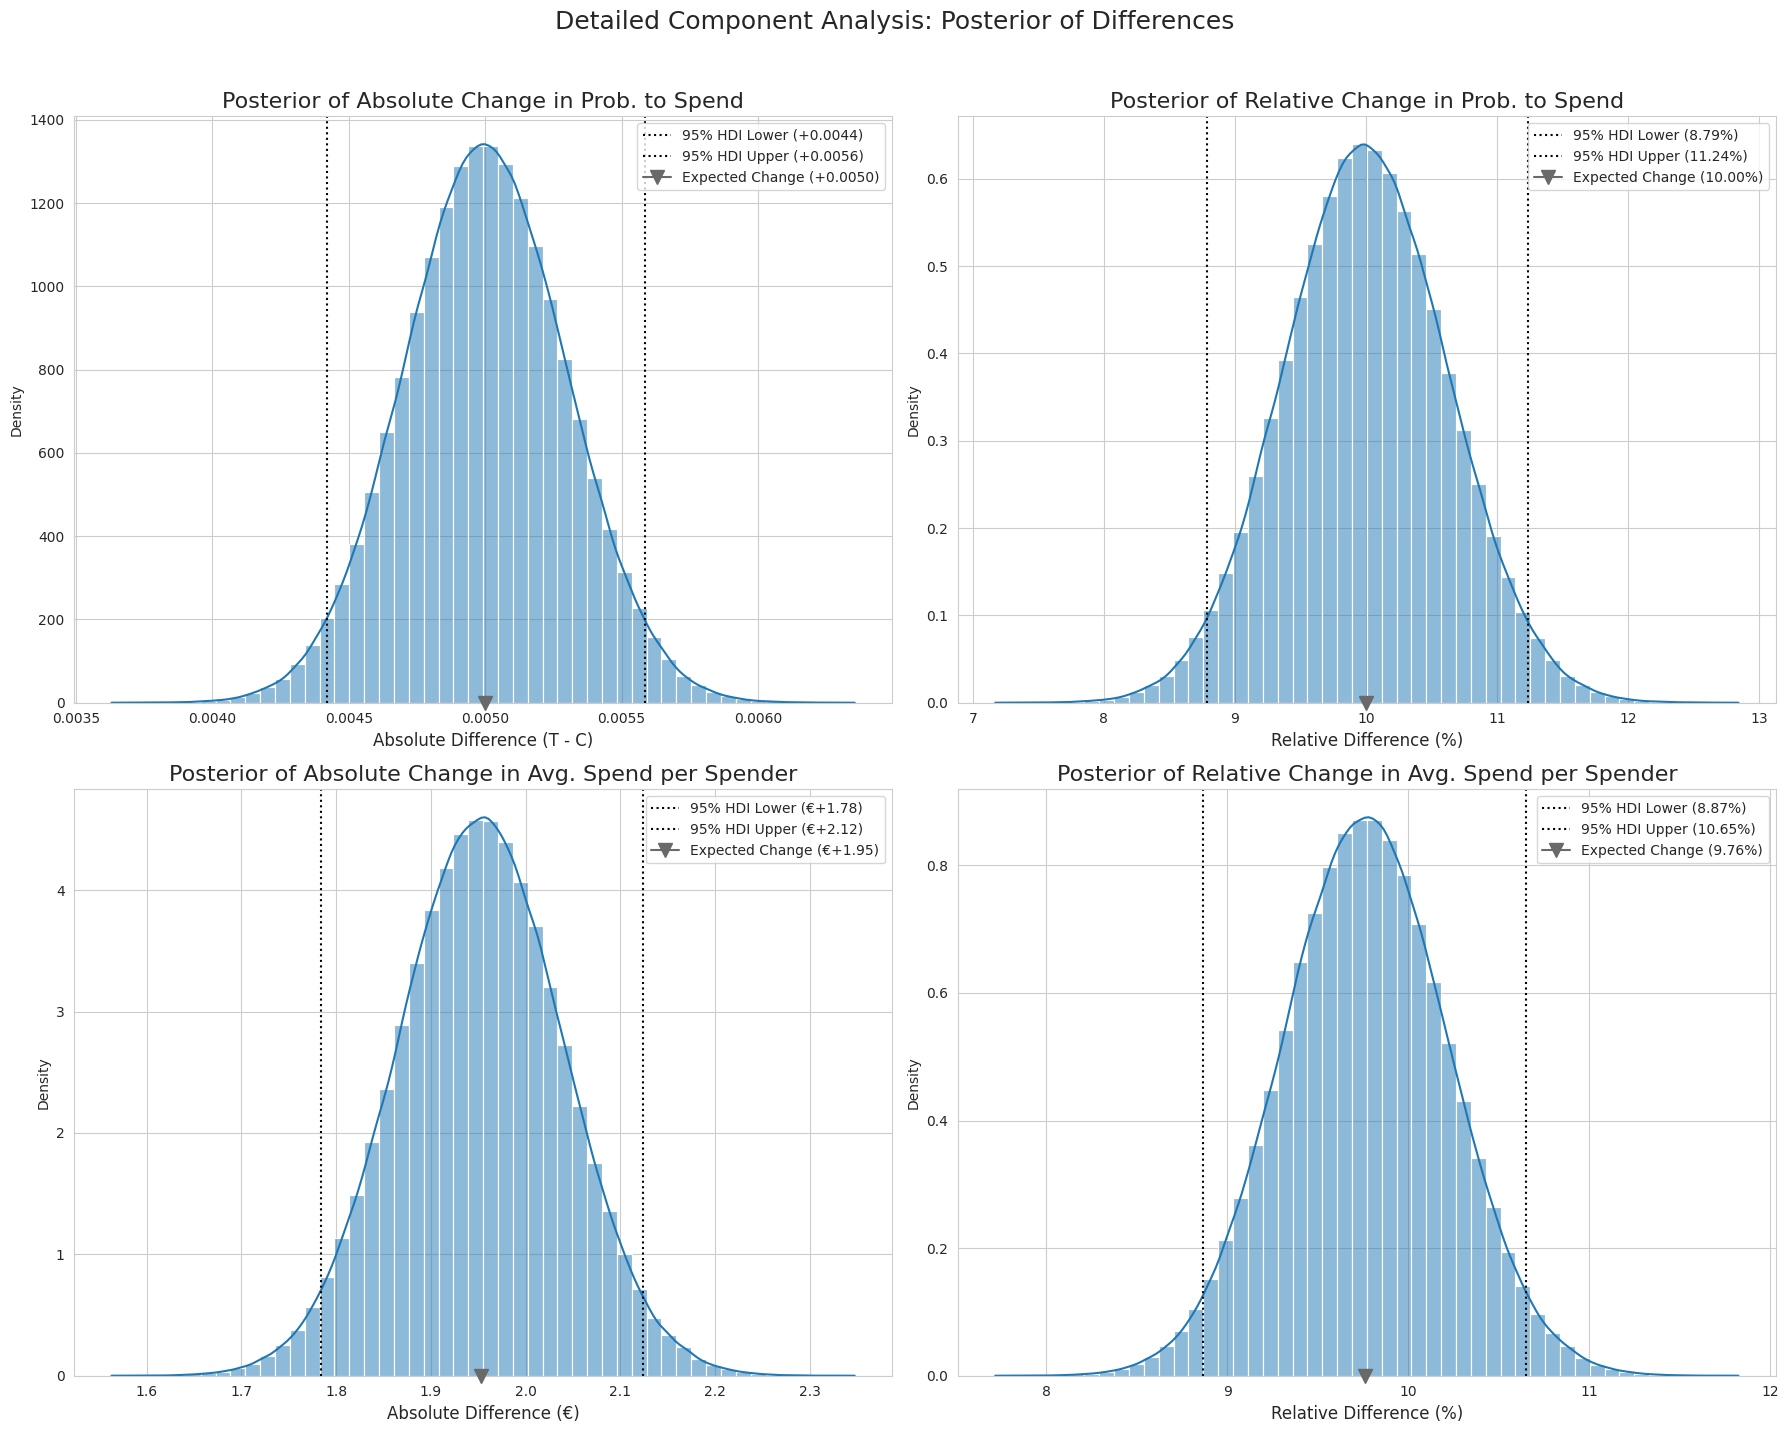

In [6]:
# --- 4.1. Analysis of Probability to Spend (The Hurdle) ---
prob_p_is_greater = np.mean(diff_p_abs_samples > 0)
expected_p_change_abs = np.mean(diff_p_abs_samples)
p_hdi_abs = az.hdi(diff_p_abs_samples, hdi_prob=0.95)
expected_p_change_rel = np.mean(diff_p_rel_samples)
p_hdi_rel = az.hdi(diff_p_rel_samples, hdi_prob=0.95)

# --- Calculate and print individual group estimates for the hurdle ---
control_p_mean = np.mean(p_control_samples)
control_p_hdi = az.hdi(p_control_samples, hdi_prob=0.95)
treatment_p_mean = np.mean(p_treatment_samples)
treatment_p_hdi = az.hdi(p_treatment_samples, hdi_prob=0.95)

print("\n--- Component 1: Probability to Spend ---")
print("This is the probability that a user will spend any amount greater than zero.\n")
print("  Individual Group Estimates:")
print(f"    - Control:   Expected Value = {control_p_mean:.3%}, 95% HDI = [{control_p_hdi[0]:.3%}, {control_p_hdi[1]:.3%}]")
print(f"    - Treatment: Expected Value = {treatment_p_mean:.3%}, 95% HDI = [{treatment_p_hdi[0]:.3%}, {treatment_p_hdi[1]:.3%}]\n")

print("  Change Analysis (Treatment - Control):")
print(f"    - Probability Treatment > Control: {prob_p_is_greater:.2%}\n")
print("    Absolute Change (percentage points):")
print(f"      - Expected Change: {expected_p_change_abs:+.4f}")
print(f"      - 95% HDI: [{p_hdi_abs[0]:+.4f}, {p_hdi_abs[1]:+.4f}]\n")
print("    Relative Change (% lift):")
print(f"      - Expected Change: {expected_p_change_rel:+.2%}")
print(f"      - 95% HDI: [{p_hdi_rel[0]:+.2%}, {p_hdi_rel[1]:+.2%}]\n")


# --- 4.2. Analysis of Average Spend per Spender (The Amount) ---
prob_avg_spend_is_greater = np.mean(diff_avg_spend_abs_samples > 0)
expected_avg_spend_change_abs = np.mean(diff_avg_spend_abs_samples)
avg_spend_hdi_abs = az.hdi(diff_avg_spend_abs_samples, hdi_prob=0.95)
expected_avg_spend_change_rel = np.mean(diff_avg_spend_rel_samples)
avg_spend_hdi_rel = az.hdi(diff_avg_spend_rel_samples, hdi_prob=0.95)

# --- Calculate and print individual group estimates for the amount ---
control_avg_spend_mean = np.mean(avg_spend_control_samples)
control_avg_spend_hdi = az.hdi(avg_spend_control_samples, hdi_prob=0.95)
treatment_avg_spend_mean = np.mean(avg_spend_treatment_samples)
treatment_avg_spend_hdi = az.hdi(avg_spend_treatment_samples, hdi_prob=0.95)

print("--- Component 2: Average Spend per Spender ---")
print("Of the users who spend > €0, this is their average spend.\n")
print("  Individual Group Estimates:")
print(f"    - Control:   Expected Value = €{control_avg_spend_mean:.2f}, 95% HDI = [€{control_avg_spend_hdi[0]:.2f}, €{control_avg_spend_hdi[1]:.2f}]")
print(f"    - Treatment: Expected Value = €{treatment_avg_spend_mean:.2f}, 95% HDI = [€{treatment_avg_spend_hdi[0]:.2f}, €{treatment_avg_spend_hdi[1]:.2f}]\n")

print("  Change Analysis (Treatment - Control):")
print(f"    - Probability Treatment > Control: {prob_avg_spend_is_greater:.2%}\n")
print("    Absolute Change (€):")
print(f"      - Expected Change: €{expected_avg_spend_change_abs:+.4f}")
print(f"      - 95% HDI: [€{avg_spend_hdi_abs[0]:.4f}, €{avg_spend_hdi_abs[1]:.4f}]\n")
print("    Relative Change (% lift):")
print(f"      - Expected Change: {expected_avg_spend_change_rel:+.2%}")
print(f"      - 95% HDI: [{avg_spend_hdi_rel[0]:+.2%}, {avg_spend_hdi_rel[1]:+.2%}]\n")

# --- Plotting the Component Differences ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Detailed Component Analysis: Posterior of Differences', fontsize=18, y=1.02)

# Plot 1a: Absolute Difference in Probability to Spend
ax = sns.histplot(diff_p_abs_samples, bins=50, kde=True, stat="density", ax=axes[0, 0])
hdi_lower, hdi_upper = p_hdi_abs
ax.axvline(hdi_lower, color='black', linestyle=':', label=f'95% HDI Lower ({hdi_lower:+.4f})')
ax.axvline(hdi_upper, color='black', linestyle=':', label=f'95% HDI Upper ({hdi_upper:+.4f})')
ax.plot([expected_p_change_abs], [ax.get_ylim()[0]], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Change ({expected_p_change_abs:+.4f})')
ax.set_title('Posterior of Absolute Change in Prob. to Spend', fontsize=16)
ax.set_xlabel('Absolute Difference (T - C)', fontsize=12)
ax.legend()

# Plot 1b: Relative Difference in Probability to Spend
ax = sns.histplot(diff_p_rel_samples * 100, bins=50, kde=True, stat="density", ax=axes[0, 1])
hdi_lower_rel, hdi_upper_rel = p_hdi_rel * 100
ax.axvline(hdi_lower_rel, color='black', linestyle=':', label=f'95% HDI Lower ({hdi_lower_rel:.2f}%)')
ax.axvline(hdi_upper_rel, color='black', linestyle=':', label=f'95% HDI Upper ({hdi_upper_rel:.2f}%)')
ax.plot([expected_p_change_rel * 100], [ax.get_ylim()[0]], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Change ({expected_p_change_rel:.2%})')
ax.set_title('Posterior of Relative Change in Prob. to Spend', fontsize=16)
ax.set_xlabel('Relative Difference (%)', fontsize=12)
ax.legend()

# Plot 2a: Absolute Difference in Average Spend per Spender
ax = sns.histplot(diff_avg_spend_abs_samples, bins=50, kde=True, stat="density", ax=axes[1, 0])
hdi_lower, hdi_upper = avg_spend_hdi_abs
ax.axvline(hdi_lower, color='black', linestyle=':', label=f'95% HDI Lower (€{hdi_lower:+.2f})')
ax.axvline(hdi_upper, color='black', linestyle=':', label=f'95% HDI Upper (€{hdi_upper:+.2f})')
ax.plot([expected_avg_spend_change_abs], [ax.get_ylim()[0]], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Change (€{expected_avg_spend_change_abs:+.2f})')
ax.set_title('Posterior of Absolute Change in Avg. Spend per Spender', fontsize=16)
ax.set_xlabel('Absolute Difference (€)', fontsize=12)
ax.legend()

# Plot 2b: Relative Difference in Average Spend per Spender
ax = sns.histplot(diff_avg_spend_rel_samples * 100, bins=50, kde=True, stat="density", ax=axes[1, 1])
hdi_lower_rel, hdi_upper_rel = avg_spend_hdi_rel * 100
ax.axvline(hdi_lower_rel, color='black', linestyle=':', label=f'95% HDI Lower ({hdi_lower_rel:.2f}%)')
ax.axvline(hdi_upper_rel, color='black', linestyle=':', label=f'95% HDI Upper ({hdi_upper_rel:.2f}%)')
ax.plot([expected_avg_spend_change_rel * 100], [ax.get_ylim()[0]], marker='v', color='dimgray', markersize=10, clip_on=False, zorder=10, label=f'Expected Change ({expected_avg_spend_change_rel:.2%})')
ax.set_title('Posterior of Relative Change in Avg. Spend per Spender', fontsize=16)
ax.set_xlabel('Relative Difference (%)', fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()

### 5. Model Validation: Posterior Predictive Checks

A crucial step in any Bayesian analysis is to check if our model is a good fit for the data. We do this with a **Posterior Predictive Check (PPC)**. The process answers the question:

> *"Can my trained model generate data that looks like the real data I observed?"*

We perform a PPC for the second part of our hurdle model: the **Gamma distribution for positive spenders**.

1.  **Draw Parameters from the Posterior:** We take thousands of samples of the rate parameter `β` from its Gamma posterior distribution.
2.  **Generate Replicated Data:** For each sampled `β_rate`, we pair it with our **fixed, point-estimated shape `α_est`**. Using this `Gamma(α_est, β_rate)` parameter set, we generate a full new dataset of the same size as our original positive spenders.
3.  **Compare Visually:** We plot the distributions of these simulated datasets (a light blue cloud) and overlay our actual data's distribution (a solid black line).

This process explicitly checks the validity of our key simplifying assumption: that a Gamma distribution with a fixed shape `α` is a good model for the spending behavior.

#### How to Interpret the Plots Below

**✅ If the check passes:**
The black line representing the actual data should look like a plausible, typical draw from the light blue cloud of simulations. It doesn't need to be a perfect match for the *average* of the simulations, but it should lie comfortably within their range. This indicates that the **Gamma distribution is a good-enough approximation** of the true data-generating process, and we can be more confident in the model's conclusions.

**❌ If the check fails:**
A failing check is a powerful diagnostic tool. It might look like:
- **Systematic Mismatch:** The black line is consistently higher or lower than the entire blue cloud.
- **Shape Mismatch:** The black line has a different shape (e.g., it's more peaked, has multiple modes, or is much more/less skewed) than the blue simulations.

A failure indicates **model misspecification**. The assumptions we made (i.e., that the data comes from a Gamma distribution with a fixed shape) are likely wrong. It means our analytical model is providing a poor description of reality.

**What to do if it fails?** You should explore alternative likelihoods. A common next step is to use a **Log-Normal distribution** (`log(spend) ~ Normal(μ, σ)`). This model is similarly flexible for skewed data but lacks the computational convenience of conjugacy, meaning you would need to switch to an MCMC-based sampler like PyMC or Stan to fit it.


--- Model Validation: Generating Posterior Predictive Checks ---



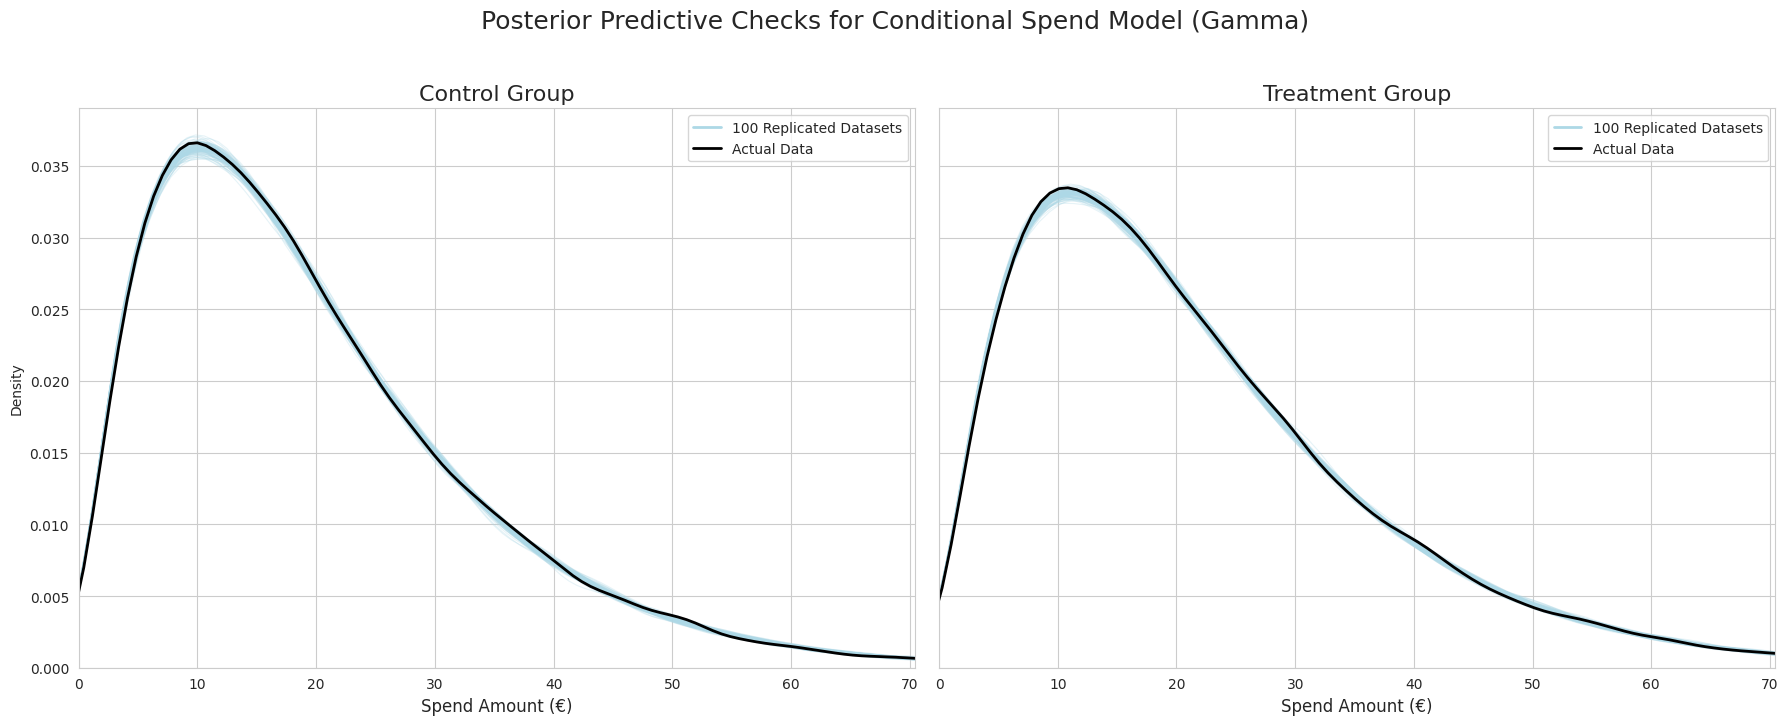

In [7]:
print("\n--- Model Validation: Generating Posterior Predictive Checks ---\n")

def plot_posterior_predictive(ax, observed_data, alpha_est, beta_rate_samples, title, n_reps=100):
    """Generates and plots posterior predictive checks for a Gamma model."""
    n_points = len(observed_data)

    # Use a subset of samples for plotting speed
    sample_indices = np.random.choice(len(beta_rate_samples), size=n_reps, replace=False)

    # Plot replicated data from the posterior
    for idx in sample_indices:
        beta_rate_sample = beta_rate_samples[idx]
        # Generate data using the fixed alpha and a sampled beta_rate
        replicated_data = np.random.gamma(shape=alpha_est, scale=1/beta_rate_sample, size=n_points)
        sns.kdeplot(replicated_data, ax=ax, color='lightblue', alpha=0.3, linewidth=0.8)

    # Overlay the actual observed data distribution
    sns.kdeplot(observed_data, ax=ax, color='black', linewidth=2, label='Actual Data')

    # --- Robust Legend Creation ---
    # Create a proxy artist for the replicated data, as they don't have a single label
    legend_elements = [
        Line2D([0], [0], color='lightblue', lw=2, label=f'{n_reps} Replicated Datasets'),
        Line2D([0], [0], color='black', lw=2, label='Actual Data')
    ]
    ax.legend(handles=legend_elements)
    # ------------------------------

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Spend Amount (€)', fontsize=12)
    
# Create temporary variables for positive spends for this cell's scope
# This avoids relying on variables created in other cells
positive_spends_control = SPEND_DATA_CONTROL[SPEND_DATA_CONTROL > 0]
positive_spends_treatment = SPEND_DATA_TREATMENT[SPEND_DATA_TREATMENT > 0]

# Create figure for comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True, sharey=True)
fig.suptitle('Posterior Predictive Checks for Conditional Spend Model (Gamma)', fontsize=18, y=1.03)

# Plot PPC for Control Group
plot_posterior_predictive(
    ax=axes[0],
    observed_data=positive_spends_control,
    alpha_est=alpha_est, # Using the single pooled alpha estimate from the analysis cell
    beta_rate_samples=beta_rate_control_samples,
    title='Control Group'
)

# Plot PPC for Treatment Group
plot_posterior_predictive(
    ax=axes[1],
    observed_data=positive_spends_treatment,
    alpha_est=alpha_est, # Using the single pooled alpha estimate from the analysis cell
    beta_rate_samples=beta_rate_treatment_samples,
    title='Treatment Group'
)

# Zoom in on the bulk of the distribution for better visualization
x_limit = np.percentile(np.concatenate([positive_spends_control, positive_spends_treatment]), 99)
axes[0].set_xlim(0, x_limit)
axes[1].set_xlim(0, x_limit)

plt.tight_layout()
plt.show()